### Бунтякова Валерия

In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Обучение модели

In [6]:
learning_rate = 0.01
epochs = 5
n_feat = 784
batch_size = 128

w1 = np.random.rand(n_feat,256)*0.01
b1 = np.zeros(256)
w2 = np.random.rand(256, 1)*0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
    
        
        # forward
        
        z1 = x.dot(w1) + b1
        a1 = 1/(1+np.exp(-z1)) # sigmoid
        z2 = a1.dot(w2) + b2
        p = 1/(1+np.exp(-z2))
        
        
        # рассчет bce
        
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        losses.append(bce)
        
        
        # backward
        
        bce_p = np.divide(1 - y, 1 - p) - np.divide(y, p) # +
        p_z2 = np.multiply(1/(1+np.exp(-z2)), 1 - 1/(1+np.exp(-z2))) # +
        z2_a1 = w2 # +
        a1_z1 = np.multiply(1/(1+np.exp(-z1)), 1 - 1/(1+np.exp(-z1))) # +
        z1_w1 = x # +
        z1_b1 = 1
        d_ = np.multiply(np.multiply(np.multiply(bce_p, p_z2), z2_a1.T), a1_z1) # +
        dw1 = np.dot(x.T, d_) # +
        try:
            db1 = np.dot(d_.T, np.ones(batch_size))
        except ValueError:
            db1 = np.dot(d_.T, np.ones(108))
        d__ = np.multiply(bce_p, p_z2)
        dw2 = np.dot(a1.T, d__)
        db2 = np.sum(d__)
              
        
        # gradient descent
        
        w1 -= learning_rate * dw1 
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


Text(0, 0.5, 'Loss function')

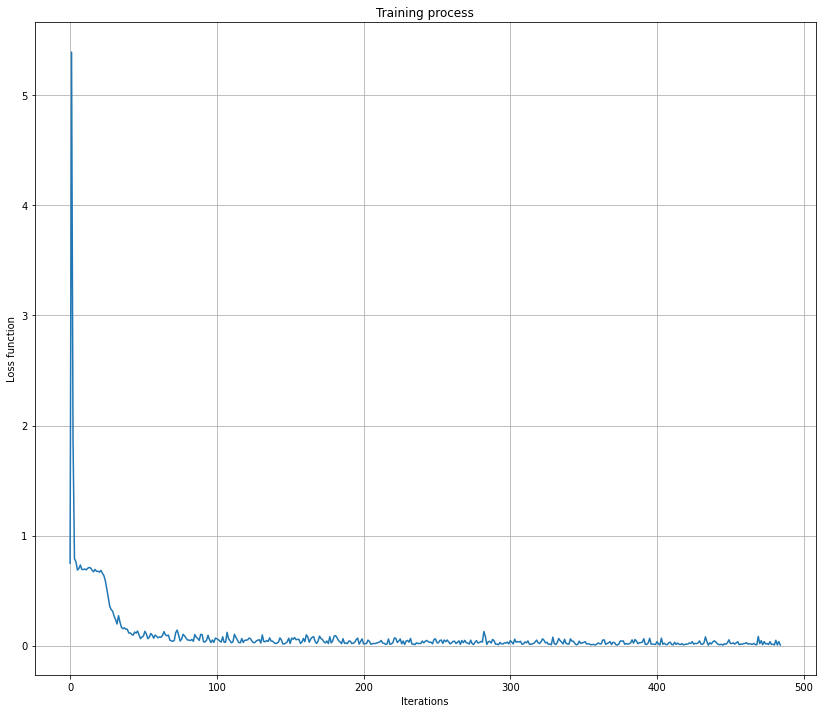

In [7]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

Форма графика какая-то странная, но может так бывает

## Тестирование

In [9]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    z1 = x.dot(w1) + b1
    a1 = 1/(1+np.exp(-z1))
    z2 = a1.dot(w2) + b2
    p = 1/(1+np.exp(-z2))

    bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 

    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y) 

In [10]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
t_lbls = np.array(true_lbls).squeeze()
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.99
